In [2]:
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys
import pickle 
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import corner

from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import sys, platform, os
from numpy import sqrt, sin, cos, pi
import scipy.constants as cst

camb_path = os.path.realpath(os.path.join(os.getcwd(),'..'))
sys.path.insert(0,camb_path)
import camb
from camb import model, initialpower
tf.__version__

'2.8.0'

In [3]:
import scipy.integrate as integrate
import scipy.special as special     
from scipy.interpolate import CubicSpline
from scipy import interpolate
from scipy.optimize import curve_fit
from scipy.integrate import quad, dblquad

In [4]:
train_params = np.load('LHS_params_7dim8000.npz')                  

In [5]:
print(train_params.files)                                       # Each of the keys has an 'np.array' of values

['h', 'omega_b', 'omega_cdm', 'ns', 'z', 'lnAs', 'w']


In [6]:
#print(train_params['omega_b'])

n_samples = len(train_params['h'])
print('number of training samples: ', len(train_params['omega_b'])) 

number of training samples:  8000


In [7]:
cosmo_params = np.zeros((len(train_params['omega_b']), 7))
print(cosmo_params[199])

cosmo_params[:, 0] = train_params['h']
cosmo_params[:, 1] = train_params['omega_b']
cosmo_params[:, 2] = train_params['omega_cdm']
cosmo_params[:, 3] = train_params['ns']
cosmo_params[:, 4] = train_params['z']
cosmo_params[:, 5] = train_params['lnAs']
cosmo_params[:, 6] = train_params['w']

[0. 0. 0. 0. 0. 0. 0.]


In [8]:
print(cosmo_params[0])
print(cosmo_params[7999])

[ 0.69722715  0.02436992  0.11675834  1.00530566  4.12614077  3.67425928
 -0.93045381]
[ 0.6535817   0.02008801  0.1867921   0.96099387  1.51268909  2.75764471
 -0.78148519]


In [9]:
len(train_params['h'])

8000

In [10]:
#%%time
## Training input params:
h = cosmo_params[:, 0]
# ombh2:
omega_b = cosmo_params[:, 1]
# omch2:
omega_c = cosmo_params[:, 2]

ns = cosmo_params[:, 3]

z = cosmo_params[:, 4]

lnAs = cosmo_params[:, 5]

w = cosmo_params[:, 6]

In [11]:
with open('pk_data_7dim8000.pkl', 'rb') as f:
    pk_matrix = pickle.load(f)

In [12]:
# Training input params and output param:

train_H0 = 100*h                               #1x8000                     # np.arrays, sizes len(train_params['h'])
train_omega_b = omega_b                        #1x8000
train_omega_c = omega_c                        #1x8000
train_ns = ns                                  #1x8000
train_z = z                                    #1x8000
train_lnAs = lnAs                              #1x8000
train_w = w                                    #1x8000
train_pk = pk_matrix                           #8000x500                 # don't need kh, stays the same

In [13]:
input_params = np.vstack([train_H0, train_omega_b, train_omega_c, train_ns, train_z, train_lnAs, train_w])        # n_samples = no. of rows

input_params_transpose = np.transpose(input_params)
print(np.shape(input_params_transpose))
print(np.shape(train_pk))

input_data = pd.DataFrame(input_params_transpose)
input_data.columns = ['H0', 'Omega_b', 'Omega_cdm', 'ns', 'z', 'lnAs', 'w']

output_data = pd.DataFrame(train_pk) 
print(np.shape(input_data))
print( input_data)                                                         #1400x3
print(np.shape(output_data))

(8000, 7)
(8000, 500)
(8000, 7)
             H0   Omega_b  Omega_cdm        ns         z      lnAs         w
0     69.722715  0.024370   0.116758  1.005306  4.126141  3.674259 -0.930454
1     74.127266  0.023610   0.097956  0.896620  4.429929  2.627141 -1.188224
2     66.878360  0.023529   0.234673  0.882444  3.211651  2.752769 -0.726691
3     70.980873  0.023553   0.154563  0.958189  2.639705  3.269259 -1.350581
4     69.688711  0.023014   0.091380  0.904972  4.728091  3.046931 -1.147606
...         ...       ...        ...       ...       ...       ...       ...
7995  68.424553  0.018129   0.219771  0.916087  3.384798  3.706438 -1.470634
7996  76.443555  0.021942   0.204244  0.988049  2.942243  3.202300 -1.407176
7997  75.991499  0.018383   0.054076  1.009386  2.730966  3.588936 -1.316377
7998  71.264908  0.024042   0.142537  0.949050  0.121265  3.531079 -1.196212
7999  65.358170  0.020088   0.186792  0.960994  1.512689  2.757645 -0.781485

[8000 rows x 7 columns]
(8000, 500)


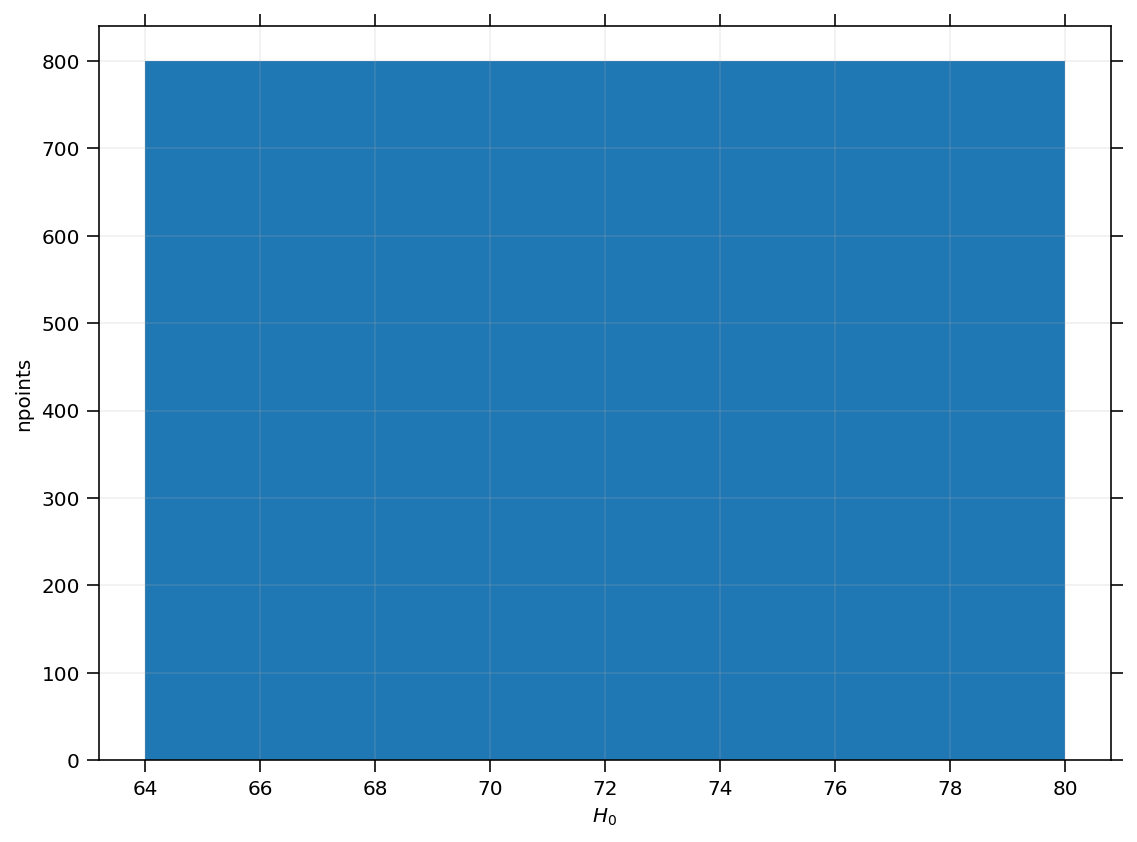

In [14]:
plt.figure(figsize = (8,6))
plt.hist(input_data['H0'])
#plt.hist(input_data['Omega_b'])
#plt.hist(input_data['Omega_cdm'])
plt.xlabel(r'$H_{0}$')
plt.ylabel('npoints')
plt.rc('axes', labelsize=16)
plt.rc('axes', labelsize=20, titlesize=20)
plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15
plt.grid(alpha=0.2)
plt.grid(alpha=0.2)
plt.tick_params(top=True,right=True, length=6)
plt.tight_layout()



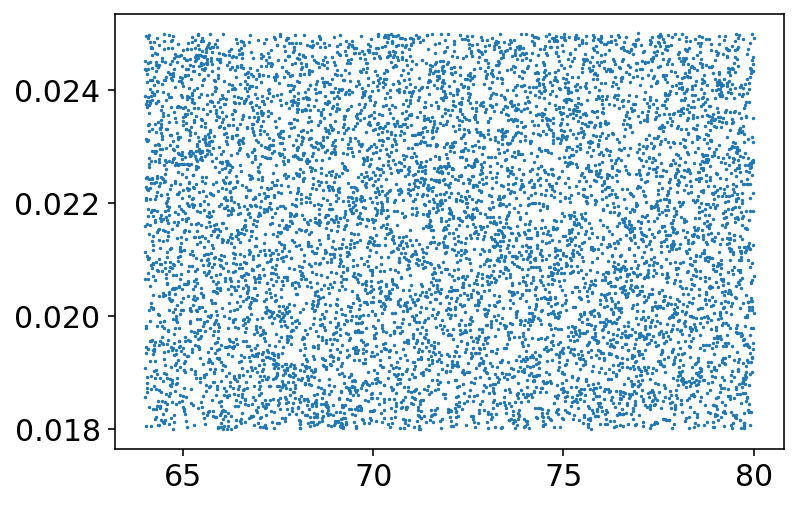

In [15]:
plt.scatter(input_data['H0'], input_data['Omega_b'], s=0.5)

In [16]:
# Standardising:

train_input_data = StandardScaler()
test_output_data = StandardScaler()

scaled_input = train_input_data.fit(input_data)                    # Compute the mean and std to be used for later scaling
scaled_output = test_output_data.fit(output_data)

# Generating the standardized values of input and output:
X = scaled_input.transform(input_data)                             # Perform standardisation by centring and scaling
y = scaled_output.transform(output_data)                           # z = (x - u) / s
print(X)

[[-0.49298496  1.42006517 -0.57569039 ...  1.12648255  1.13037967
   0.460076  ]
 [ 0.46050901  1.04421014 -0.90131595 ...  1.33692673 -1.65952119
  -0.53195611]
 [-1.10872903  1.00393996  1.46639753 ...  0.49298496 -1.32480237
   1.24426201]
 ...
 [ 0.86407685 -1.54217475 -1.66125324 ...  0.15999819  0.903048
  -1.02515758]
 [-0.15913217  1.2576854  -0.12925429 ... -1.64782985  0.74889547
  -0.56270001]
 [-1.43781869 -0.698666    0.6371782  ... -0.68394357 -1.31181199
   1.03338482]]


-1.7318343147478867 10.161470992411216


(array([[800., 800., 800., 800., 800., 800., 800., 800., 800., 800.],
        [800., 800., 800., 800., 800., 800., 800., 800., 800., 800.],
        [800., 800., 800., 800., 800., 800., 800., 800., 800., 800.],
        [800., 800., 800., 800., 800., 800., 800., 800., 800., 800.],
        [800., 800., 800., 800., 800., 800., 800., 800., 800., 800.],
        [800., 800., 800., 800., 800., 800., 800., 800., 800., 800.],
        [800., 800., 800., 800., 800., 800., 800., 800., 800., 800.]]),
 array([-1.73183431e+00, -1.38546745e+00, -1.03910059e+00, -6.92733726e-01,
        -3.46366863e-01,  6.66133815e-16,  3.46366863e-01,  6.92733726e-01,
         1.03910059e+00,  1.38546745e+00,  1.73183431e+00]),
 <a list of 7 BarContainer objects>)

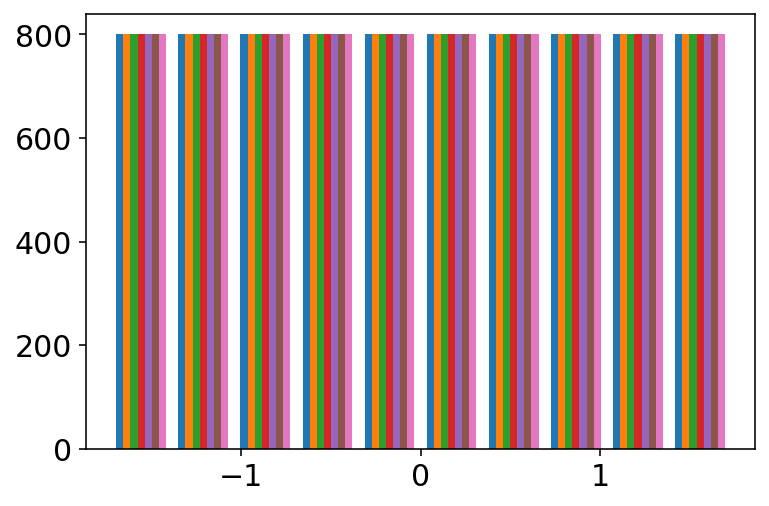

In [17]:
print(X.min(), y.max())
plt.hist(X)

In [18]:
# Storing the fit object for later reference

# Split the data into training and testing sets:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
print(np.shape(X_train))    # 6800x7
print(X_train.shape[1])     # 7

(6800, 7)
7


In [19]:
print(X_train)

[[ 7.85918060e-02  6.98666000e-01  2.53095926e-01 ...  1.13817390e+00
  -7.38286662e-02 -9.28812253e-02]
 [ 1.40729129e-02 -1.16112357e+00 -2.16722859e-01 ... -9.68432915e-01
  -1.31874019e+00 -9.06079086e-01]
 [-1.22044631e+00 -1.29838860e+00 -2.95964184e-01 ...  1.65735613e+00
   9.89650538e-01 -1.57118660e+00]
 ...
 [ 7.33956535e-02  1.02429155e+00  4.37992351e-01 ...  5.17233676e-01
  -1.62163258e-01  3.57235482e-02]
 [ 1.64306671e+00 -1.21178606e+00  2.26682151e-01 ... -1.91608122e-01
   1.27673796e+00  1.67381061e+00]
 [ 1.05287039e+00 -1.40404370e+00  1.54953597e+00 ...  3.64813204e-01
  -1.41270395e+00  6.49519058e-04]]


In [20]:
print("y_test samples, pts:", np.shape(y_test))
print("y_train samples, pts:", np.shape(y_train))
print("X_train samples, pts:", np.shape(X_train))
print("X_test ssamples, pts:",np.shape(X_test))
print("X_train:", X_train)
print("X_test:", X_test)

y_test samples, pts: (1200, 500)
y_train samples, pts: (6800, 500)
X_train samples, pts: (6800, 7)
X_test ssamples, pts: (1200, 7)
X_train: [[ 7.85918060e-02  6.98666000e-01  2.53095926e-01 ...  1.13817390e+00
  -7.38286662e-02 -9.28812253e-02]
 [ 1.40729129e-02 -1.16112357e+00 -2.16722859e-01 ... -9.68432915e-01
  -1.31874019e+00 -9.06079086e-01]
 [-1.22044631e+00 -1.29838860e+00 -2.95964184e-01 ...  1.65735613e+00
   9.89650538e-01 -1.57118660e+00]
 ...
 [ 7.33956535e-02  1.02429155e+00  4.37992351e-01 ...  5.17233676e-01
  -1.62163258e-01  3.57235482e-02]
 [ 1.64306671e+00 -1.21178606e+00  2.26682151e-01 ... -1.91608122e-01
   1.27673796e+00  1.67381061e+00]
 [ 1.05287039e+00 -1.40404370e+00  1.54953597e+00 ...  3.64813204e-01
  -1.41270395e+00  6.49519058e-04]]
X_test: [[-1.39235235  0.94634927 -1.09530564 ...  1.08015019  0.77487624
   1.19663061]
 [ 0.63891025 -1.03728194  1.47765586 ...  1.35684531  1.19792965
   0.23880651]
 [ 1.72533912  1.40317767 -0.96366978 ... -0.73070894 

In [ ]:
%%time
#ADAPTIVE LEARNING RATE:
#Building the NN:

tf_model = Sequential()
# Defining the input layer of the model
tf_model.add(Dense(units=500, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))
# Initializers define the way to set the initial random weights of Keras layers (generate no.s from normal dist. in this case)

# Defining 1st Hidden layer of the model
tf_model.add(Dense(units=500, kernel_initializer='normal', activation='relu'))

tf_model.add(Dropout(0.2))

# Defining 2nd Hidden layer of the model
tf_model.add(Dense(units=500, kernel_initializer='normal', activation='relu'))

# Defining 3rd Hidden layer of the model
#tf_model.add(Dense(units=500, kernel_initializer='normal', activation='relu'))

# Defining the 4th hidden layer of the model
#tf_model.add(Dense(units=350, kernel_initializer='normal', activation='relu')) 

#Defining the output layer of the model
tf_model.add(Dense(500, kernel_initializer='normal'))
 
opt=tf.keras.optimizers.RMSprop(lr=0.001, epsilon=1e-08)
    
# Compiling the model
tf_model.compile(optimizer=opt, loss='mean_squared_error', metrics=['accuracy'])
 
# Fitting the ANN to the Training set
hist_ = tf_model.fit(X_train, y_train, batch_size = 50, epochs = 800, validation_split=0.2, verbose=1)
            
# Mean absolute percentage error
MAPE = np.mean(np.abs((y_test - tf_model.predict(X_test))/y_test))*100
print(np.shape(100-MAPE))
print('Accuracy:', 100-MAPE)
#8.7 acc., RMSprop opt., lr=0.001, epsilon=1e-08, 500 epochs, 500 units, Dropout 0.2, 2 hidden layers, less overfitting 
tf_model.summary()

Epoch 1/800


C:\Users\HP\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


109/109 [==============================] - 2s 13ms/step - loss: 0.2159 - accuracy: 0.0301 - val_loss: 0.0848 - val_accuracy: 0.0581
Epoch 2/800
109/109 [==============================] - 1s 11ms/step - loss: 0.0874 - accuracy: 0.0704 - val_loss: 0.0761 - val_accuracy: 0.1037
Epoch 3/800
109/109 [==============================] - 1s 12ms/step - loss: 0.0681 - accuracy: 0.1176 - val_loss: 0.0334 - val_accuracy: 0.1838
Epoch 4/800
109/109 [==============================] - 1s 12ms/step - loss: 0.0487 - accuracy: 0.1779 - val_loss: 0.0320 - val_accuracy: 0.2794
Epoch 5/800
109/109 [==============================] - 1s 11ms/step - loss: 0.0428 - accuracy: 0.2237 - val_loss: 0.0222 - val_accuracy: 0.3206
Epoch 6/800
109/109 [==============================] - 1s 11ms/step - loss: 0.0355 - accuracy: 0.2559 - val_loss: 0.0165 - val_accuracy: 0.3250
Epoch 7/800
109/109 [==============================] - 1s 11ms/step - loss: 0.0295 - accuracy: 0.2835 - val_loss: 0.1569 - val_accuracy: 0.2022
Epoc

109/109 [==============================] - 1s 13ms/step - loss: 0.0083 - accuracy: 0.5085 - val_loss: 0.0036 - val_accuracy: 0.6574
Epoch 58/800
109/109 [==============================] - 1s 13ms/step - loss: 0.0086 - accuracy: 0.5066 - val_loss: 0.0061 - val_accuracy: 0.6088
Epoch 59/800
109/109 [==============================] - 1s 12ms/step - loss: 0.0083 - accuracy: 0.5118 - val_loss: 0.0065 - val_accuracy: 0.5853
Epoch 60/800
109/109 [==============================] - 1s 11ms/step - loss: 0.0077 - accuracy: 0.5046 - val_loss: 0.0060 - val_accuracy: 0.5684
Epoch 61/800
109/109 [==============================] - 1s 11ms/step - loss: 0.0073 - accuracy: 0.5208 - val_loss: 0.0026 - val_accuracy: 0.6390
Epoch 62/800
109/109 [==============================] - 1s 11ms/step - loss: 0.0082 - accuracy: 0.5210 - val_loss: 0.0026 - val_accuracy: 0.6353
Epoch 63/800
109/109 [==============================] - 1s 12ms/step - loss: 0.0069 - accuracy: 0.5224 - val_loss: 0.0178 - val_accuracy: 0.552

109/109 [==============================] - 1s 10ms/step - loss: 0.0053 - accuracy: 0.5551 - val_loss: 0.0032 - val_accuracy: 0.6772
Epoch 114/800
109/109 [==============================] - 1s 10ms/step - loss: 0.0053 - accuracy: 0.5722 - val_loss: 0.0065 - val_accuracy: 0.6338
Epoch 115/800
109/109 [==============================] - 1s 10ms/step - loss: 0.0054 - accuracy: 0.5711 - val_loss: 0.0060 - val_accuracy: 0.6551
Epoch 116/800
109/109 [==============================] - 1s 10ms/step - loss: 0.0054 - accuracy: 0.5627 - val_loss: 0.0033 - val_accuracy: 0.6493
Epoch 117/800
109/109 [==============================] - 1s 10ms/step - loss: 0.0051 - accuracy: 0.5634 - val_loss: 0.0114 - val_accuracy: 0.6221
Epoch 118/800
109/109 [==============================] - 1s 10ms/step - loss: 0.0056 - accuracy: 0.5594 - val_loss: 0.0116 - val_accuracy: 0.6434
Epoch 119/800
109/109 [==============================] - 1s 11ms/step - loss: 0.0048 - accuracy: 0.5654 - val_loss: 0.0030 - val_accuracy:

109/109 [==============================] - 1s 11ms/step - loss: 0.0041 - accuracy: 0.5835 - val_loss: 0.0020 - val_accuracy: 0.6985
Epoch 170/800
109/109 [==============================] - 1s 11ms/step - loss: 0.0038 - accuracy: 0.6007 - val_loss: 0.0022 - val_accuracy: 0.6816
Epoch 171/800
109/109 [==============================] - 1s 11ms/step - loss: 0.0040 - accuracy: 0.5947 - val_loss: 0.0111 - val_accuracy: 0.6926
Epoch 172/800
109/109 [==============================] - 1s 11ms/step - loss: 0.0036 - accuracy: 0.5939 - val_loss: 0.0064 - val_accuracy: 0.6750
Epoch 173/800
109/109 [==============================] - 1s 11ms/step - loss: 0.0041 - accuracy: 0.5949 - val_loss: 0.0099 - val_accuracy: 0.6691
Epoch 174/800
109/109 [==============================] - 1s 11ms/step - loss: 0.0042 - accuracy: 0.5908 - val_loss: 0.0019 - val_accuracy: 0.6934
Epoch 175/800
109/109 [==============================] - 1s 11ms/step - loss: 0.0038 - accuracy: 0.5890 - val_loss: 0.0066 - val_accuracy:

109/109 [==============================] - 1s 10ms/step - loss: 0.0036 - accuracy: 0.6108 - val_loss: 0.0012 - val_accuracy: 0.7103
Epoch 226/800
109/109 [==============================] - 1s 10ms/step - loss: 0.0031 - accuracy: 0.6189 - val_loss: 0.0013 - val_accuracy: 0.6985
Epoch 227/800
109/109 [==============================] - 1s 10ms/step - loss: 0.0033 - accuracy: 0.6096 - val_loss: 0.0010 - val_accuracy: 0.7463
Epoch 228/800
109/109 [==============================] - 1s 10ms/step - loss: 0.0032 - accuracy: 0.6143 - val_loss: 0.0021 - val_accuracy: 0.7360
Epoch 229/800
109/109 [==============================] - 1s 10ms/step - loss: 0.0033 - accuracy: 0.6075 - val_loss: 0.0015 - val_accuracy: 0.6993
Epoch 230/800
109/109 [==============================] - 1s 10ms/step - loss: 0.0031 - accuracy: 0.6062 - val_loss: 0.0047 - val_accuracy: 0.6809
Epoch 231/800
109/109 [==============================] - 1s 10ms/step - loss: 0.0036 - accuracy: 0.6143 - val_loss: 8.1143e-04 - val_accur

Epoch 281/800
109/109 [==============================] - 1s 11ms/step - loss: 0.0028 - accuracy: 0.6169 - val_loss: 0.0014 - val_accuracy: 0.7265
Epoch 282/800
109/109 [==============================] - 1s 11ms/step - loss: 0.0030 - accuracy: 0.6336 - val_loss: 0.0010 - val_accuracy: 0.7390
Epoch 283/800
109/109 [==============================] - 1s 11ms/step - loss: 0.0028 - accuracy: 0.6222 - val_loss: 0.0020 - val_accuracy: 0.6890
Epoch 284/800
109/109 [==============================] - 1s 11ms/step - loss: 0.0024 - accuracy: 0.6384 - val_loss: 0.0029 - val_accuracy: 0.6993
Epoch 285/800
109/109 [==============================] - 1s 11ms/step - loss: 0.0032 - accuracy: 0.6322 - val_loss: 0.0010 - val_accuracy: 0.7199
Epoch 286/800
109/109 [==============================] - 1s 11ms/step - loss: 0.0028 - accuracy: 0.6278 - val_loss: 0.0013 - val_accuracy: 0.7265
Epoch 287/800
109/109 [==============================] - 1s 11ms/step - loss: 0.0029 - accuracy: 0.6221 - val_loss: 7.4447e-

Epoch 337/800
109/109 [==============================] - 1s 11ms/step - loss: 0.0028 - accuracy: 0.6485 - val_loss: 0.0022 - val_accuracy: 0.7471
Epoch 338/800
109/109 [==============================] - 1s 11ms/step - loss: 0.0024 - accuracy: 0.6454 - val_loss: 0.0017 - val_accuracy: 0.7353
Epoch 339/800
109/109 [==============================] - 1s 11ms/step - loss: 0.0026 - accuracy: 0.6410 - val_loss: 9.6572e-04 - val_accuracy: 0.7162
Epoch 340/800
109/109 [==============================] - 1s 11ms/step - loss: 0.0023 - accuracy: 0.6263 - val_loss: 0.0010 - val_accuracy: 0.7324
Epoch 341/800
109/109 [==============================] - 1s 11ms/step - loss: 0.0023 - accuracy: 0.6300 - val_loss: 8.8618e-04 - val_accuracy: 0.7316
Epoch 342/800
109/109 [==============================] - 1s 11ms/step - loss: 0.0026 - accuracy: 0.6408 - val_loss: 0.0051 - val_accuracy: 0.7390
Epoch 343/800
109/109 [==============================] - 1s 11ms/step - loss: 0.0027 - accuracy: 0.6392 - val_loss: 

109/109 [==============================] - 1s 10ms/step - loss: 0.0022 - accuracy: 0.6460 - val_loss: 0.0011 - val_accuracy: 0.7191
Epoch 393/800
109/109 [==============================] - 1s 12ms/step - loss: 0.0024 - accuracy: 0.6399 - val_loss: 7.7099e-04 - val_accuracy: 0.7449
Epoch 394/800
109/109 [==============================] - 1s 11ms/step - loss: 0.0021 - accuracy: 0.6419 - val_loss: 0.0018 - val_accuracy: 0.7471
Epoch 395/800
109/109 [==============================] - 1s 12ms/step - loss: 0.0020 - accuracy: 0.6395 - val_loss: 0.0013 - val_accuracy: 0.7279
Epoch 396/800
109/109 [==============================] - 1s 13ms/step - loss: 0.0023 - accuracy: 0.6456 - val_loss: 0.0010 - val_accuracy: 0.7551
Epoch 397/800
109/109 [==============================] - 1s 12ms/step - loss: 0.0022 - accuracy: 0.6469 - val_loss: 8.6297e-04 - val_accuracy: 0.7478
Epoch 398/800
109/109 [==============================] - 1s 12ms/step - loss: 0.0021 - accuracy: 0.6373 - val_loss: 5.0999e-04 - v

109/109 [==============================] - 1s 12ms/step - loss: 0.0019 - accuracy: 0.6438 - val_loss: 9.0953e-04 - val_accuracy: 0.7647
Epoch 448/800
109/109 [==============================] - 1s 12ms/step - loss: 0.0019 - accuracy: 0.6502 - val_loss: 6.8632e-04 - val_accuracy: 0.7640
Epoch 449/800
109/109 [==============================] - 1s 10ms/step - loss: 0.0020 - accuracy: 0.6426 - val_loss: 8.4629e-04 - val_accuracy: 0.7662
Epoch 450/800
109/109 [==============================] - 1s 10ms/step - loss: 0.0021 - accuracy: 0.6465 - val_loss: 6.5262e-04 - val_accuracy: 0.7897
Epoch 451/800
109/109 [==============================] - 1s 10ms/step - loss: 0.0019 - accuracy: 0.6410 - val_loss: 0.0016 - val_accuracy: 0.7213
Epoch 452/800
109/109 [==============================] - 1s 10ms/step - loss: 0.0022 - accuracy: 0.6528 - val_loss: 0.0018 - val_accuracy: 0.7551
Epoch 453/800
109/109 [==============================] - 1s 10ms/step - loss: 0.0020 - accuracy: 0.6515 - val_loss: 9.3088

109/109 [==============================] - 1s 10ms/step - loss: 0.0019 - accuracy: 0.6520 - val_loss: 6.5267e-04 - val_accuracy: 0.7588
Epoch 503/800
109/109 [==============================] - 1s 10ms/step - loss: 0.0019 - accuracy: 0.6539 - val_loss: 0.0027 - val_accuracy: 0.7735
Epoch 504/800
109/109 [==============================] - 1s 10ms/step - loss: 0.0020 - accuracy: 0.6430 - val_loss: 4.5621e-04 - val_accuracy: 0.7441
Epoch 505/800
109/109 [==============================] - 1s 10ms/step - loss: 0.0021 - accuracy: 0.6450 - val_loss: 0.0052 - val_accuracy: 0.6949
Epoch 506/800
109/109 [==============================] - 1s 10ms/step - loss: 0.0019 - accuracy: 0.6496 - val_loss: 7.9535e-04 - val_accuracy: 0.7397
Epoch 507/800
109/109 [==============================] - 1s 11ms/step - loss: 0.0019 - accuracy: 0.6450 - val_loss: 0.0016 - val_accuracy: 0.7324
Epoch 508/800
109/109 [==============================] - 1s 11ms/step - loss: 0.0019 - accuracy: 0.6531 - val_loss: 4.3451e-04

109/109 [==============================] - 1s 11ms/step - loss: 0.0015 - accuracy: 0.6574 - val_loss: 0.0040 - val_accuracy: 0.7566
Epoch 558/800
109/109 [==============================] - 1s 10ms/step - loss: 0.0018 - accuracy: 0.6533 - val_loss: 9.2443e-04 - val_accuracy: 0.7809
Epoch 559/800
109/109 [==============================] - 1s 11ms/step - loss: 0.0017 - accuracy: 0.6531 - val_loss: 4.5324e-04 - val_accuracy: 0.7860
Epoch 560/800
109/109 [==============================] - 1s 10ms/step - loss: 0.0021 - accuracy: 0.6603 - val_loss: 6.9432e-04 - val_accuracy: 0.7772
Epoch 561/800
109/109 [==============================] - 1s 10ms/step - loss: 0.0017 - accuracy: 0.6621 - val_loss: 0.0018 - val_accuracy: 0.7456
Epoch 562/800
109/109 [==============================] - 1s 11ms/step - loss: 0.0017 - accuracy: 0.6502 - val_loss: 8.1326e-04 - val_accuracy: 0.7853
Epoch 563/800
109/109 [==============================] - 1s 12ms/step - loss: 0.0016 - accuracy: 0.6528 - val_loss: 6.9669

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

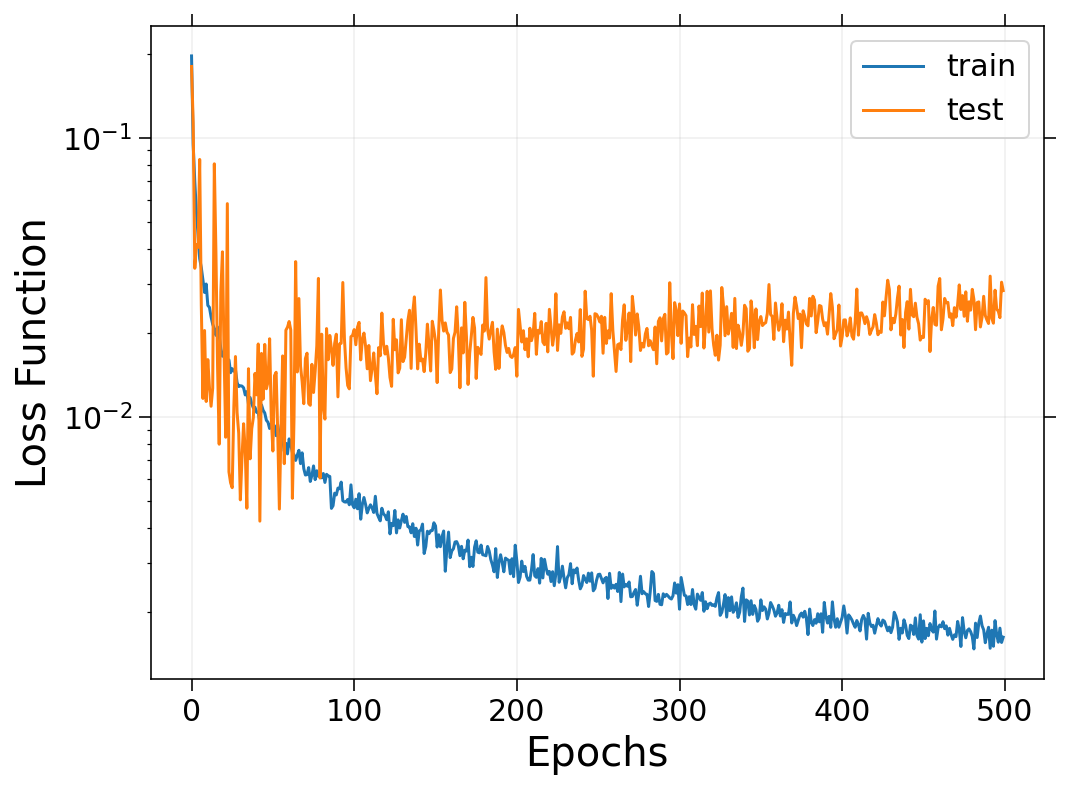

In [23]:
plt.figure(figsize = (8,6))
plt.plot(hist_.history["loss"], label="train")
plt.plot(hist_.history["val_loss"], label="test")
plt.legend(fontsize=15)
plt.yscale("log")
plt.xlabel('Epochs')
plt.ylabel('Loss Function')
plt.rc('axes', labelsize=16)
plt.rc('axes', labelsize=20, titlesize=20)
plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15
plt.grid(alpha=0.2)
plt.grid(alpha=0.2)
plt.tick_params(top=True,right=True, length=6)
plt.tight_layout

H0: 64.0 - 80.0, Omega_b: 0.0180 - 0.0250, Omega_cdm: 0.050 - 0.250, ns: 0.88 - 1.05, z: 0.0 - 5.0, lnAs: 2.60 - 3.90, w: -1.5 - -0.6 75 0.0250 0.050 0.88 5.0 2.60 -1.5


parameters:  ['75', '0.0250', '0.050', '0.88', '5.0', '2.60', '-1.5']
user_list: [75.0, 0.025, 0.05, 0.88, 5.0, 2.6, -1.5]
cosmo_arr [[ 7.5e+01  2.5e-02  5.0e-02  8.8e-01  5.0e+00  2.6e+00 -1.5e+00]]
cosmo_arr[0] [ 7.5e+01  2.5e-02  5.0e-02  8.8e-01  5.0e+00  2.6e+00 -1.5e+00]
input_scaled [[ 0.64943787  1.73183431 -1.73183431 -1.73183431  1.73183431 -1.73183431
  -1.73183431]]


C:\Users\HP\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


H0: 75.0 Omega_b: 0.025 Omega_c: 0.05 ns: 0.88 z: 5.0 lnAs: 2.6 w: -1.5


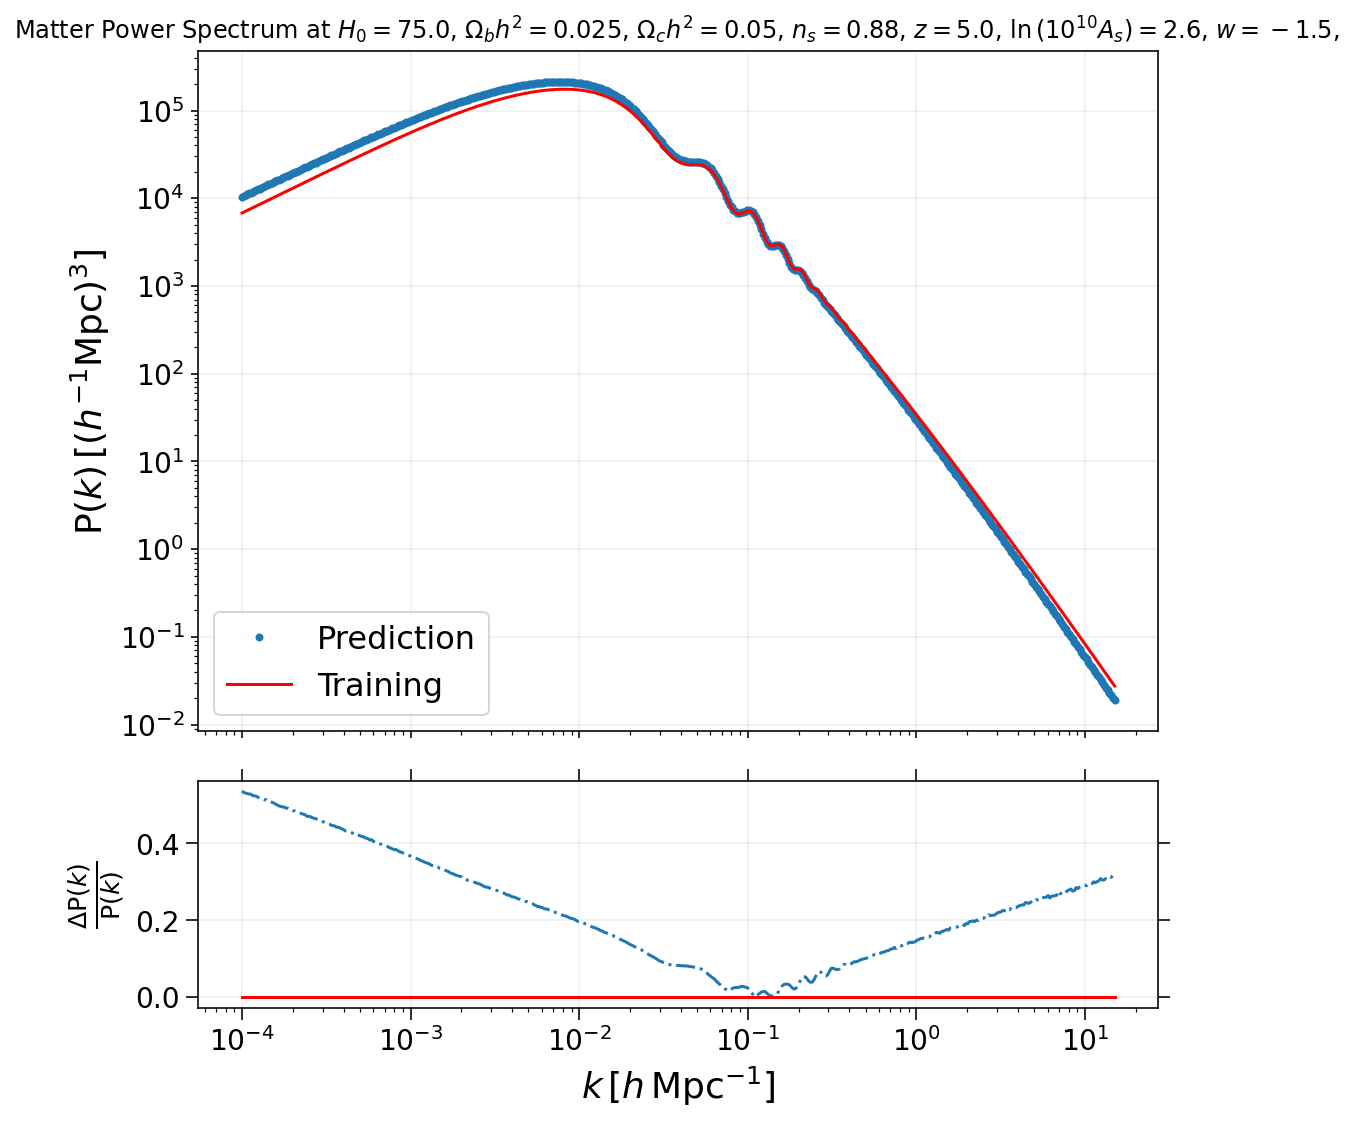

In [26]:
#Define func:

def calc_cosmo():
    input_cosmo_val = input('H0: 64.0 - 80.0, Omega_b: 0.0180 - 0.0250, Omega_cdm: 0.050 - 0.250, ns: 0.88 - 1.05, z: 0.0 - 5.0, lnAs: 2.60 - 3.90, w: -1.5 - -0.6 ')
    print("\n")
    user_list = input_cosmo_val.split()
    print('parameters: ', user_list)

    # convert each item to float type
    for i in range(len(user_list)):
        # convert each item to float type
        user_list[i] = float(user_list[i])
    print("user_list:", user_list)
        
    
    cosmo_arr = np.reshape(np.array(user_list),(1, X_train.shape[1]))
    print('cosmo_arr', cosmo_arr)
    print('cosmo_arr[0]', cosmo_arr[0])
    scaled = train_input_data.fit(input_data)
    input_scaled = scaled.transform(cosmo_arr)
    print('input_scaled', input_scaled)
    
    pred_pk = scaled_output.inverse_transform(tf_model.predict([input_scaled]))
    
    
    #Compute P.S via CAMB:
    pars = camb.CAMBparams()
    pars.set_cosmology(H0=cosmo_arr[0][0], ombh2=cosmo_arr[0][1], omch2=cosmo_arr[0][2])
    pars.InitPower.set_params(As = np.exp(cosmo_params[i,5])/(10**10), ns=cosmo_params[i,3])
    pars.set_matter_power(redshifts=[cosmo_params[i,4]], kmax=15.0)
    pars.set_dark_energy(w=cosmo_params[i,6], wa=0, dark_energy_model='fluid')

    # Linear spectra
    pars.NonLinear = model.NonLinear_none
    results = camb.get_results(pars)
    camb_kh, z, camb_pk_cur = results.get_matter_power_spectrum(minkh=1e-4, maxkh=15, npoints=500)
    s8_current = np.array(results.get_sigma8())
    s8_fid = np.array([0.8102])
    renorm_s8 = (s8_fid/s8_current)**2
    camb_pk = renorm_s8*camb_pk_cur
    

    print('H0:' , cosmo_arr[0][0], 'Omega_b:', cosmo_arr[0][1], 'Omega_c:', cosmo_arr[0][2], 'ns:', cosmo_arr[0][3], 'z:', cosmo_arr[0][4], 'lnAs:', cosmo_arr[0][5], 'w:', cosmo_arr[0][6])
    #print(pred_pk)
    
    fig, ax = plt.subplots(2,1, sharex=True, figsize = (8,8), gridspec_kw={'height_ratios': [3, 1]})                                            
    ax[0].loglog(camb_kh, pred_pk[0], "C0.")                                    
    #plt.loglog(X_test, y_test, "C1d")
    ax[0].loglog(camb_kh, camb_pk[0], 'r')                              
    ax[0].set_title('Matter Power Spectrum at $H_{0} = %0.5s$, ' %cosmo_arr[0][0] + '$\Omega_{b}h^{2} = %0.6s$, ' %cosmo_arr[0][1] + '$\Omega_{c}h^{2} = %0.6s$, ' %cosmo_arr[0][2] + '$n_{s} = %0.4s$, ' %cosmo_arr[0][3] + '$z = %0.4s$, ' %cosmo_arr[0][4] + '$\ln{(10^{10}A_{s})} = %0.6s$, ' %cosmo_arr[0][5] + '$w = %0.6s$, ' %cosmo_arr[0][6],   fontsize = 12)
    plt.rc('axes', labelsize=18)
    plt.rc('axes', titlesize=16)
    plt.rcParams['xtick.labelsize']=14
    plt.rcParams['ytick.labelsize']=14
    plt.xlabel(r'$k\,[h\,\mathrm{Mpc}^{-1}]$')
    ax[0].set_ylabel(r'$\mathrm{P}(k)\, [(h^{-1}\mathrm{Mpc})^{3}]$')
    ax[0].legend(['Prediction', 'Training'], loc='lower left', fontsize=16);
    ax[0].grid(alpha=0.2)
    ax[1].grid(alpha=0.2)
    plt.tick_params(top=True,right=True, length=6)
    
    
    #residual plot 
    ax[1].set_ylabel(r'$\frac{\Delta \mathrm{P}(k)}{\mathrm{P}(k)}$')
    ax[1].plot(camb_kh, np.abs((pred_pk[0]-camb_pk[0])/camb_pk[0]), 'C0', linestyle="dashdot") 
    ax[1].plot(camb_kh, np.abs((camb_pk[0]-camb_pk[0])/camb_pk[0]), 'r')
    ax[1].set_yscale('linear')
    fig.tight_layout()
    #ax[1].set_ylim(0, 0.05)
    #plt.savefig('power_spectrum_H0.pdf')
    plt.show()
    

Generate = calc_cosmo()